<a href="https://colab.research.google.com/github/ShadaElewa/Pokemon-Classification/blob/main/Final_Pok%C3%A9mon_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pokemon:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F121%2F280%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T101115Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5ec51ff5717fdf6698f5884e786910f0f46dadc986bfaf021c242f6c62358bbb39cbd0670bd8765419fb5a63b10fdd2d1ee7d93e8a34da453c91e671dd538ca627d87811ece2b2d8529ac46aea9ead34b9ea29670e3d68d0c0bbd7870f335857aa5dab247f8a56270266c337c7435e69353b6a2c25f211b131b72d2d365c59fae2a2a5a1f4f0e04194b18950ed97ead3e74b37ca6002e914f9347cf0af8916c5d66b2367beb30234225d115a5086054fdae33f6bc0eb22ba8813802db93f2b336d19a69bc58e540589d64a27144351b6ac171840f412026c17163f20a48449ed7ad7cd0653f88c845abb4e80b9547470ed1a79e02656906c39c323e602c12fcf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15234 bytes downloaded
Downloaded and uncompressed: pokemon
Data source import complete.


# AI - Final Project
### Class 14
### Names :
Shada Hazem Mohammed - 12200081
Sama Mahmoud Abdelbaset - 12200353

***

## Legendary Pokémon Classification  

Given *data about various Pokémon*, let's try to predict if a given Pokémon is **legendary** or not.  
  
We will use a TensorFlow ANN to make our predictions.

# Getting Started

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.decomposition import PCA

In [4]:
data = pd.read_csv('../input/pokemon/Pokemon.csv')

In [5]:
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [6]:
data_raw = data.copy()

# Cleaning

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [8]:
data.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [9]:
data = data.drop(['#', 'Name', 'Type 2'], axis=1)

In [11]:
data['Legendary'] = data['Legendary'].astype(int)


In [12]:
data

,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,318,45,49,49,65,65,45,1,0
1,Grass,405,60,62,63,80,80,60,1,0
2,Grass,525,80,82,83,100,100,80,1,0
3,Grass,625,80,100,123,122,120,80,1,0
4,Fire,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...
795,Rock,600,50,100,150,100,150,50,6,1
796,Rock,700,50,160,110,160,110,110,6,1
797,Psychic,600,80,110,60,150,130,70,6,1
798,Psychic,680,80,160,60,170,130,80,6,1


# EDA

In [13]:
data['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [14]:
numeric_columns = data.drop('Type 1', axis=1).columns

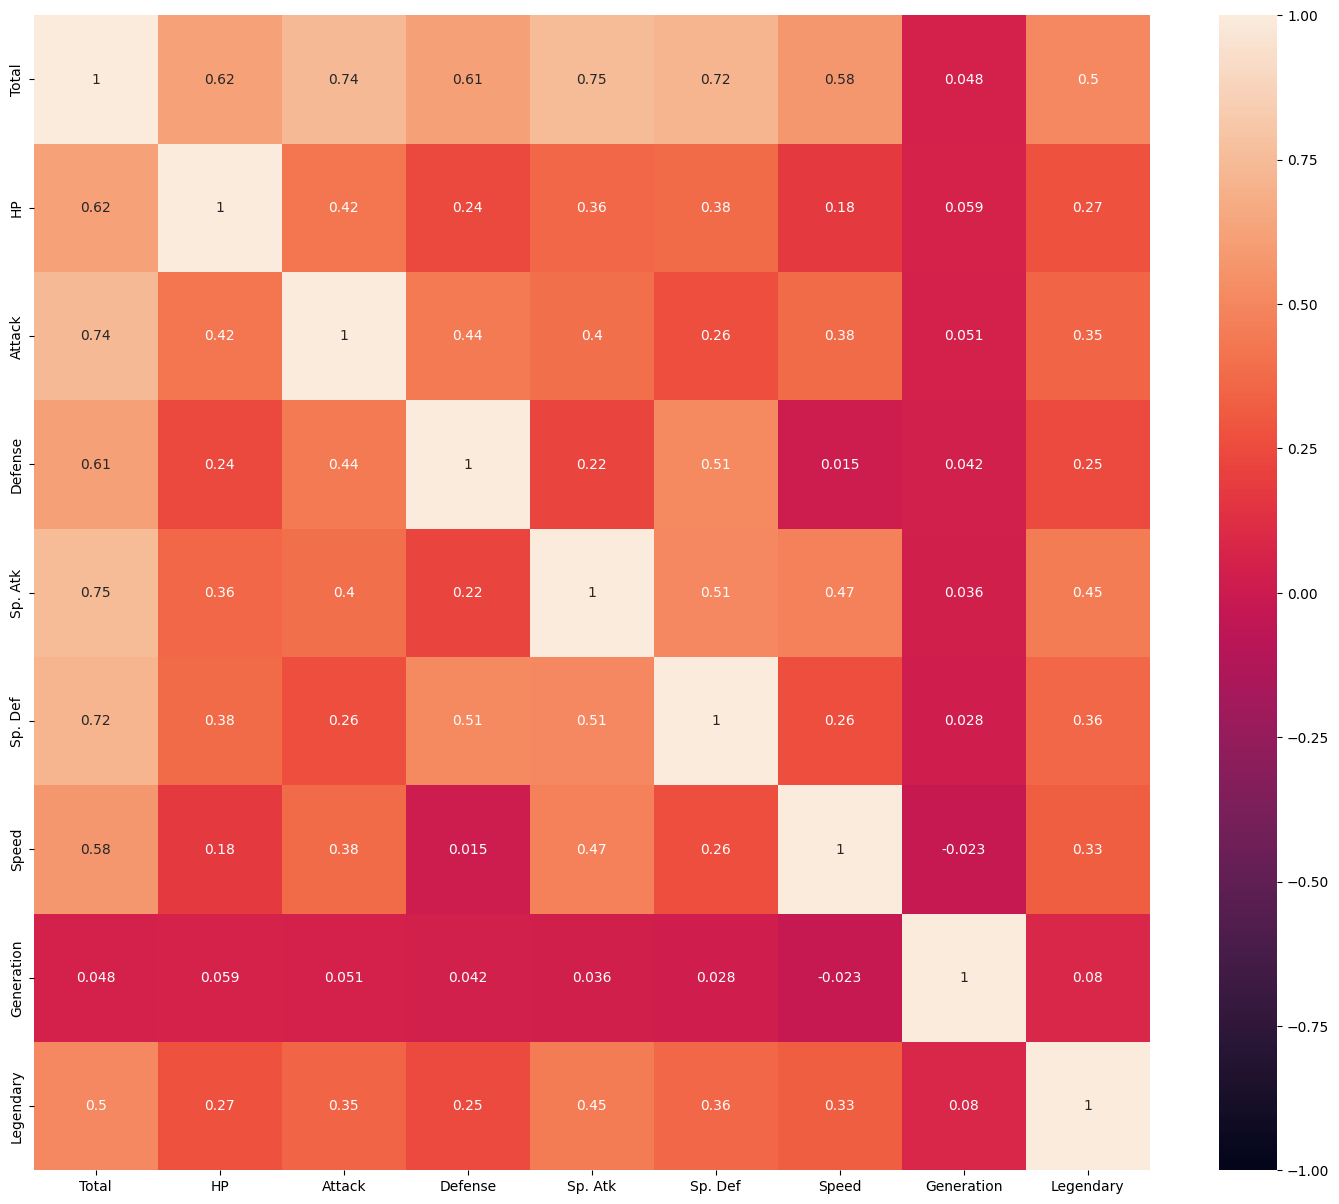

In [15]:
correlation_matrix = data[numeric_columns].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

<ipython-input-16-6e6c82ec4c87>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
<ipython-input-16-6e6c82ec4c87>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
<ipython-input-16-6e6c82ec4c87>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
<ipython-input-16-6e6c82ec4c87>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
<ipython-input-16-6e6c82ec4c87>:3: FutureWarning: 

`shade` is now deprecate

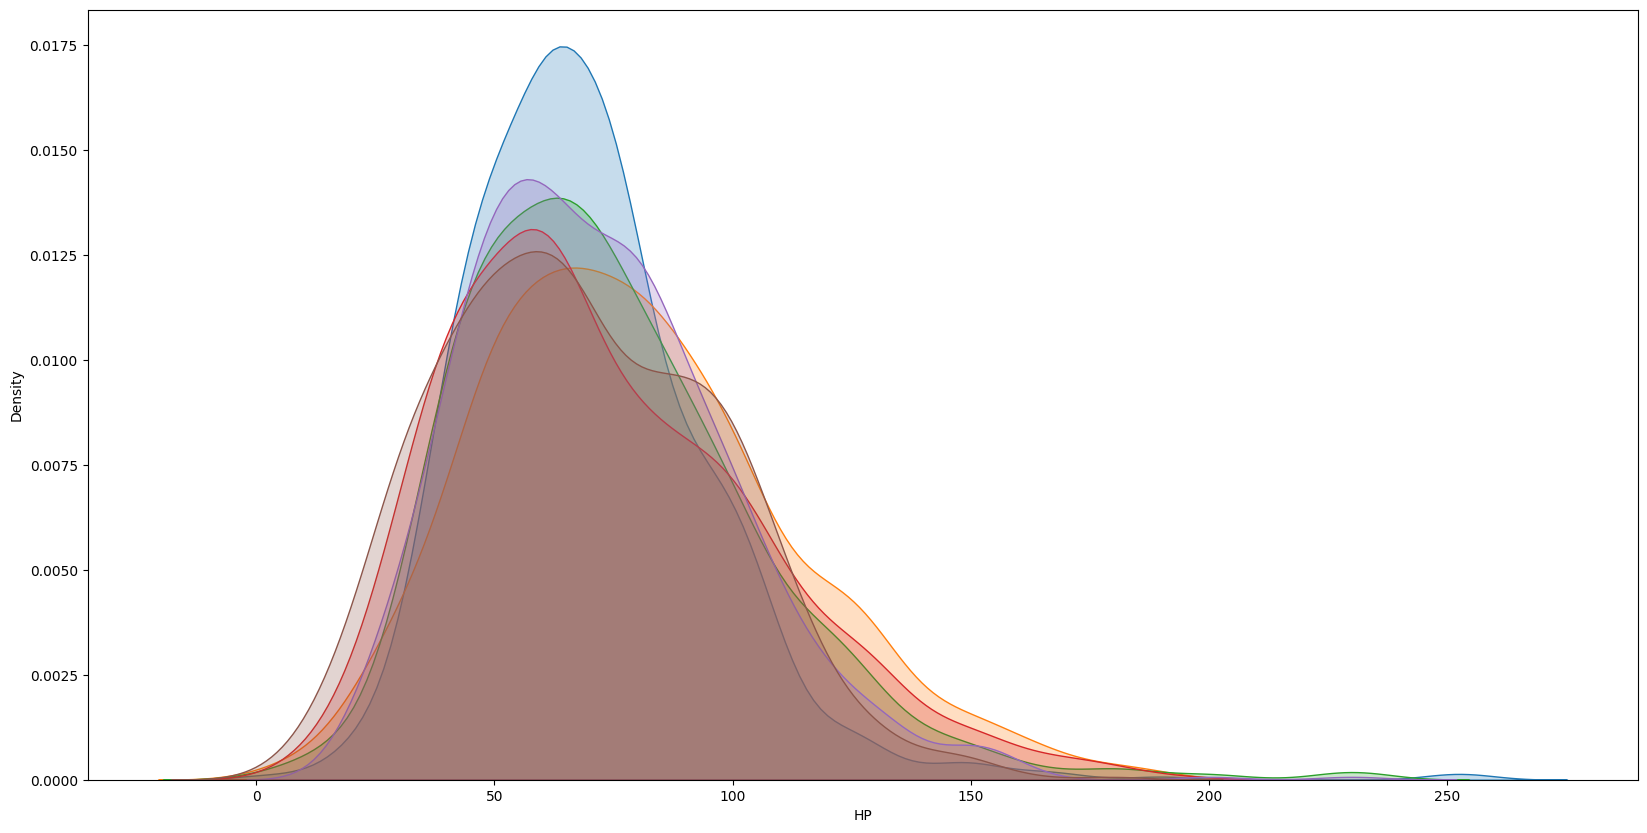

In [16]:
plt.figure(figsize=(20, 10))
for column in ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    sns.kdeplot(data[column], shade=True)
plt.show()

# Preprocessing

In [17]:
data.dtypes

Type 1        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary      int64
dtype: object

## Encoding

In [18]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [19]:
data = onehot_encode(data, 'Type 1', 't')

In [20]:
data

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,t_Bug,...,t_Ghost,t_Grass,t_Ground,t_Ice,t_Normal,t_Poison,t_Psychic,t_Rock,t_Steel,t_Water
0,318,45,49,49,65,65,45,1,0,False,...,False,True,False,False,False,False,False,False,False,False
1,405,60,62,63,80,80,60,1,0,False,...,False,True,False,False,False,False,False,False,False,False
2,525,80,82,83,100,100,80,1,0,False,...,False,True,False,False,False,False,False,False,False,False
3,625,80,100,123,122,120,80,1,0,False,...,False,True,False,False,False,False,False,False,False,False
4,309,39,52,43,60,50,65,1,0,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50,6,1,False,...,False,False,False,False,False,False,False,True,False,False
796,700,50,160,110,160,110,110,6,1,False,...,False,False,False,False,False,False,False,True,False,False
797,600,80,110,60,150,130,70,6,1,False,...,False,False,False,False,False,False,True,False,False,False
798,680,80,160,60,170,130,80,6,1,False,...,False,False,False,False,False,False,True,False,False,False


## Splitting and Scaling

In [21]:
y = data['Legendary']
X = data.drop('Legendary', axis=1)

In [22]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Training

In [24]:
X.shape

(800, 26)

In [25]:
inputs = tf.keras.Input(shape=(26,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


batch_size = 32
epochs = 20

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0
)

# Results

In [26]:
fig_loss = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'x': "Epoch", 'y':"Loss"},
    title="Loss Over Time"
)

fig_loss.show()

In [27]:
np.argmin(history.history['val_loss'])

14

In [28]:
fig_auc = px.line(
    history.history,
    y=['auc', 'val_auc'],
    labels={'x': "Epoch", 'y':"AUC"},
    title="AUC Over Time"
)

fig_auc.show()

In [29]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.1266 - accuracy: 0.9583 - auc: 0.9655


[0.12657922506332397, 0.9583333134651184, 0.9654815196990967]

# Post-Training Analysis

In [31]:
predictions = np.hstack((model.predict(X_test) >= 0.5).astype(int)) != y_test
predictions


8/8 [==============================] - 0s 3ms/step


696    False
667    False
63     False
533    False
66     False
       ...  
220    False
450    False
380    False
132    False
375    False
Name: Legendary, Length: 240, dtype: bool

In [32]:
mislabeled_indices = y_test[predictions].index

In [33]:
data_raw.loc[mislabeled_indices, :]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
306,282,GardevoirMega Gardevoir,Psychic,Fairy,618,68,85,65,165,135,100,3,False
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
275,254,SceptileMega Sceptile,Grass,Dragon,630,70,110,75,145,85,145,3,False
715,648,MeloettaAria Forme,Normal,Psychic,600,100,77,77,128,128,90,5,False
409,373,SalamenceMega Salamence,Dragon,Flying,700,95,145,130,120,90,120,3,False
776,706,Goodra,Dragon,NaN,600,90,100,70,110,150,80,6,False
264,245,Suicune,Water,NaN,580,100,75,115,90,115,85,2,True
527,475,GalladeMega Gallade,Psychic,Fighting,618,68,165,95,65,115,110,4,False
158,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True
165,151,Mew,Psychic,NaN,600,100,100,100,100,100,100,1,False


In [34]:
X.shape

(800, 26)

In [35]:
pca = PCA(n_components=2)
data_reduced = pd.DataFrame(pca.fit_transform(data), columns=["PC1", "PC2"])

In [36]:
data_reduced

,PC1,PC2
0,-125.860535,-5.210496
1,-32.131498,-5.769779
2,97.225136,-5.394538
3,206.065317,18.625769
4,-135.910526,-21.594064
...,...,...
795,179.904137,67.081536
796,290.419171,-20.944313
797,181.100238,-27.664645
798,269.322935,-37.485121


In [37]:
legendary_indices = data.query("Legendary == 1").index

mislabeled_legendary_indices = np.intersect1d(mislabeled_indices, legendary_indices)

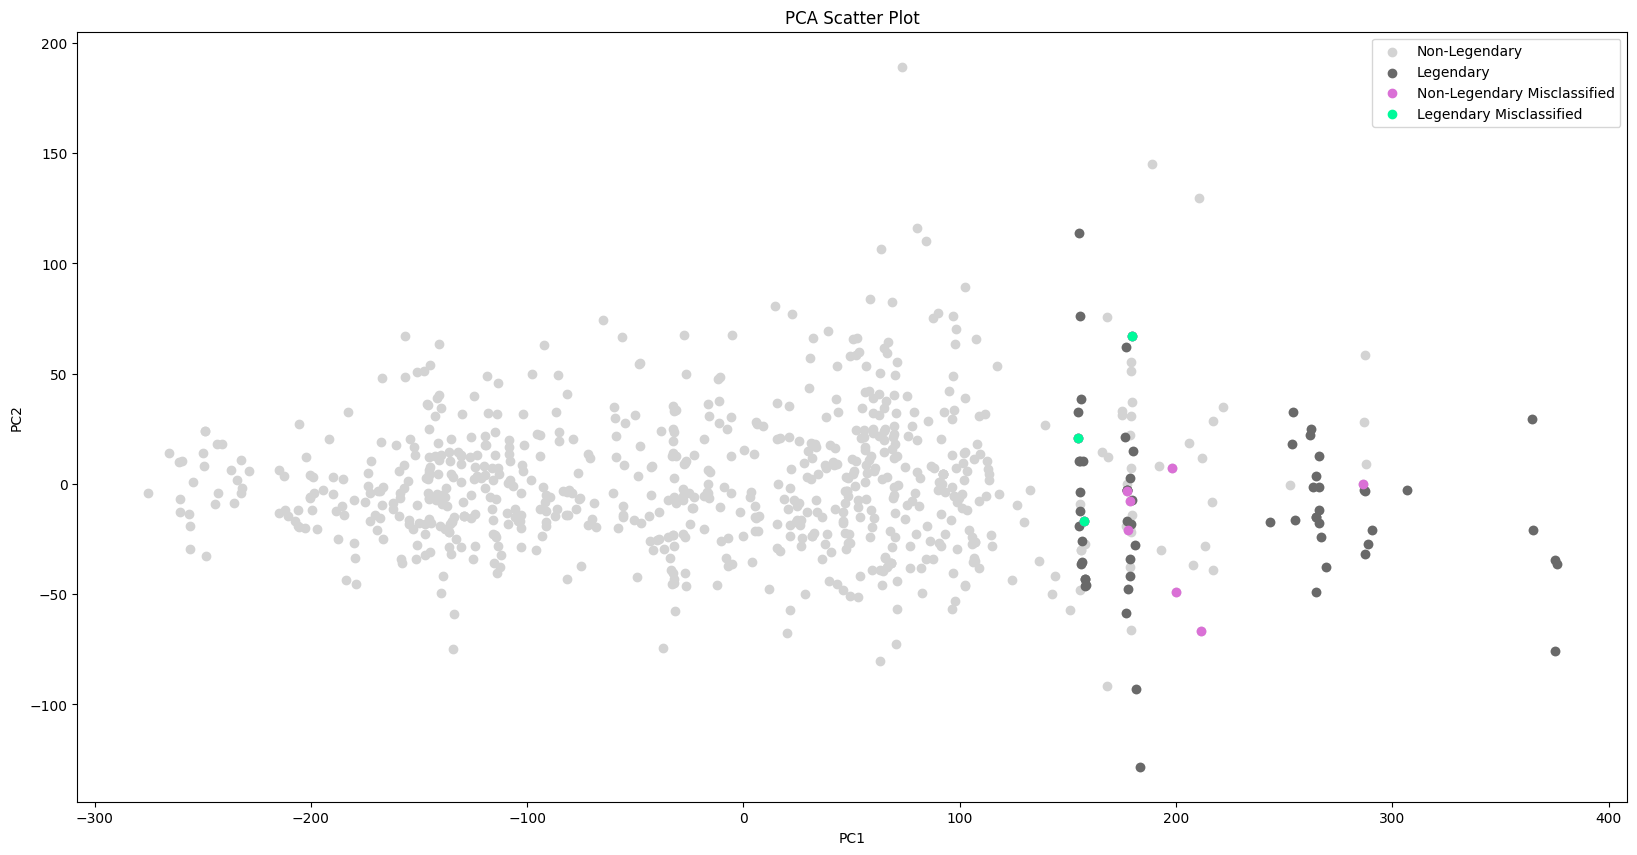

In [38]:
plt.figure(figsize=(20, 10))

plt.scatter(data_reduced['PC1'], data_reduced['PC2'], c='lightgray')
plt.scatter(data_reduced.loc[legendary_indices, 'PC1'], data_reduced.loc[legendary_indices, 'PC2'], c='dimgray')
plt.scatter(data_reduced.loc[mislabeled_indices, 'PC1'], data_reduced.loc[mislabeled_indices, 'PC2'], c='orchid')
plt.scatter(data_reduced.loc[mislabeled_legendary_indices, 'PC1'], data_reduced.loc[mislabeled_legendary_indices, 'PC2'], c='mediumspringgreen')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(['Non-Legendary', 'Legendary', 'Non-Legendary Misclassified', 'Legendary Misclassified'])
plt.title("PCA Scatter Plot")
plt.show()